In [335]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [336]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [337]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227857 entries, 0 to 2227856
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 34.0 MB


# reduce to 1 million events

In [338]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [339]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,17883,0.20,17.883
1,17966,0.20,17.966
2,17859,0.20,17.859
3,17988,0.20,17.988
4,18097,0.20,18.097
...,...,...,...
999995,27810,0.13,27.810
999996,29681,0.12,29.681
999997,29490,0.12,29.490
999998,29640,0.12,29.640


In [340]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [341]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [342]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

25988065101000

### Calcul de la date de base = now - cumul_interval

In [343]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 7, 21, 12, 11, 27, 978245)

In [344]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [345]:
conso_data.iloc[0]


Interval     17883.000000
kWh              0.200000
sec             17.883000
Wh             201.308505
cumul(ms)    17883.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [346]:
base

datetime.datetime(2024, 7, 21, 12, 11, 27, 978245)

## créer les dates

In [347]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-07-21 12:11:45.861245
1        2024-07-21 12:12:03.827245
2        2024-07-21 12:12:21.686245
3        2024-07-21 12:12:39.674245
4        2024-07-21 12:12:57.771245
                    ...            
999995   2025-05-18 07:03:55.018245
999996   2025-05-18 07:04:24.699245
999997   2025-05-18 07:04:54.189245
999998   2025-05-18 07:05:23.829245
999999   2025-05-18 07:05:53.079245
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [348]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,17883,0.20,17.883,201.308505,17883,2024-07-21 12:11:45.861245,21/07/24
1,17966,0.20,17.966,200.378493,35849,2024-07-21 12:12:03.827245,21/07/24
2,17859,0.20,17.859,201.579036,53708,2024-07-21 12:12:21.686245,21/07/24
3,17988,0.20,17.988,200.133422,71696,2024-07-21 12:12:39.674245,21/07/24
4,18097,0.20,18.097,198.927999,89793,2024-07-21 12:12:57.771245,21/07/24
...,...,...,...,...,...,...,...
999995,27810,0.13,27.810,129.449838,25987947040,2025-05-18 07:03:55.018245,18/05/25
999996,29681,0.12,29.681,121.289714,25987976721,2025-05-18 07:04:24.699245,18/05/25
999997,29490,0.12,29.490,122.075280,25988006211,2025-05-18 07:04:54.189245,18/05/25
999998,29640,0.12,29.640,121.457490,25988035851,2025-05-18 07:05:23.829245,18/05/25


### save conso_data with dates

In [349]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [350]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('18/05/25', 18, 5, 2025, '07:06:07')

In [351]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [352]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 999219 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   781 non-null    int64         
 1   kWh        781 non-null    float64       
 2   sec        781 non-null    float64       
 3   Wh         781 non-null    float64       
 4   cumul(ms)  781 non-null    int64         
 5   dates      781 non-null    datetime64[ns]
 6   days       781 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 48.8+ KB


In [353]:
end = time.time()
print(end - start)

19.528013944625854


### grouped by days

In [354]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [355]:
data = list(df_grp['kWh'])
print(data)

[2.072, 3.558, 3.7, 3.601, 3.431, 3.254, 3.191, 2.852, 3.048, 3.316, 4.091, 3.862, 2.999, 3.321, 3.347, 3.512, 3.648, 3.495, 3.671, 3.784, 3.875, 3.656, 4.371, 4.308, 3.91, 3.882, 4.042, 3.79, 3.849, 3.707, 3.291, 3.916, 3.953, 4.443, 3.778, 4.109, 3.799, 3.97, 3.76, 3.969, 3.661, 3.66, 3.494, 3.676, 3.507, 4.142, 3.716, 3.448, 3.552, 3.23, 2.462, 1.794, 1.793, 1.793, 1.796, 2.478, 1.86, 1.788, 1.791, 1.79, 1.821, 1.822, 1.815, 1.816, 1.819, 1.818, 1.815, 1.814, 1.785, 1.786, 1.785, 1.786, 1.783, 1.797, 1.787, 1.791, 1.784, 1.796, 1.803, 1.795, 1.803, 1.796, 1.785, 1.79, 1.785, 1.79, 1.797, 1.791, 1.801, 1.803, 1.795, 1.8, 1.798, 2.785, 3.998, 3.652, 3.913, 3.094, 3.565, 4.03, 3.44, 3.368, 3.975, 3.341, 4.168, 3.084, 4.036, 3.15, 3.352, 3.479, 4.009, 3.291, 3.37, 3.824, 3.226, 3.534, 3.358, 3.872, 3.406, 3.66, 3.413, 4.468, 3.656, 3.833, 3.461, 4.098, 3.493, 3.418, 3.497, 3.676, 3.738, 4.058, 3.547, 3.471, 3.697, 3.155, 3.694, 3.75, 3.324, 3.837, 3.268, 4.034, 3.389, 3.854, 3.966, 3.48

In [356]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [357]:
end = time.time()
print(end - start)

19.981987714767456


### plot function by day
#### show('dd/mm/yy')

In [358]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


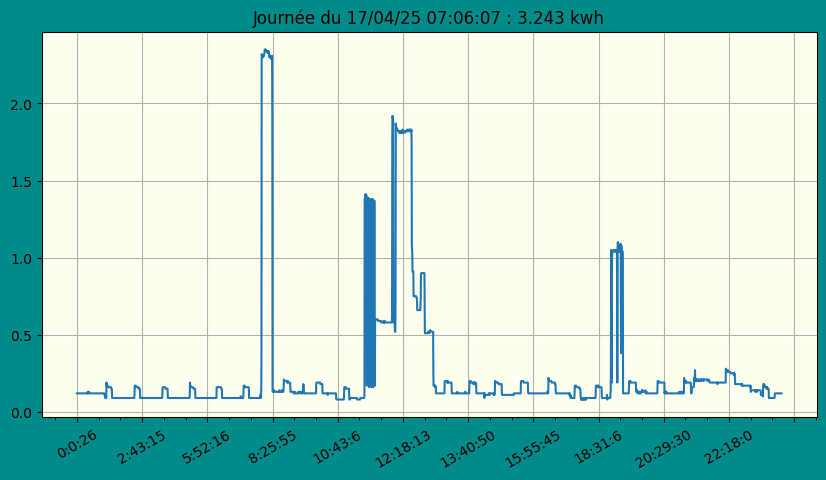

In [359]:
show('17/04/25')

In [360]:
end = time.time()
print(end - start)

21.060556173324585


### 1 kWh window in data of one day
#### df = conso_day

In [361]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999219,36219,0.10,36.219,99.395345,25962532489,2025-05-18 00:00:20.467245,18/05/25
999220,34296,0.10,34.296,104.968509,25962566785,2025-05-18 00:00:54.763245,18/05/25
999221,34327,0.10,34.327,104.873715,25962601112,2025-05-18 00:01:29.090245,18/05/25
999222,35615,0.10,35.615,101.081005,25962636727,2025-05-18 00:02:04.705245,18/05/25
999223,35918,0.10,35.918,100.228298,25962672645,2025-05-18 00:02:40.623245,18/05/25
...,...,...,...,...,...,...,...
999995,27810,0.13,27.810,129.449838,25987947040,2025-05-18 07:03:55.018245,18/05/25
999996,29681,0.12,29.681,121.289714,25987976721,2025-05-18 07:04:24.699245,18/05/25
999997,29490,0.12,29.490,122.075280,25988006211,2025-05-18 07:04:54.189245,18/05/25
999998,29640,0.12,29.640,121.457490,25988035851,2025-05-18 07:05:23.829245,18/05/25


In [362]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [363]:
df = conso_day
len(df)

781

In [364]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-05-18 00:00:20.467245	2025-05-18 07:05:53.079245	7h 5m 32s 	781


In [365]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.301819
dtype: float64

In [366]:
end = time.time()
print(end - start)

21.426993131637573


## mean for data grouped by days

In [367]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.311258
dtype: float64

In [368]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(0.781)

# conso by date


In [369]:
# select day
day = today

#day = '16/08/24'
day

'18/05/25'

In [370]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999219,36219,0.10,36.219,99.395345,25962532489,2025-05-18 00:00:20.467245,18/05/25
999220,34296,0.10,34.296,104.968509,25962566785,2025-05-18 00:00:54.763245,18/05/25
999221,34327,0.10,34.327,104.873715,25962601112,2025-05-18 00:01:29.090245,18/05/25
999222,35615,0.10,35.615,101.081005,25962636727,2025-05-18 00:02:04.705245,18/05/25
999223,35918,0.10,35.918,100.228298,25962672645,2025-05-18 00:02:40.623245,18/05/25
...,...,...,...,...,...,...,...
999995,27810,0.13,27.810,129.449838,25987947040,2025-05-18 07:03:55.018245,18/05/25
999996,29681,0.12,29.681,121.289714,25987976721,2025-05-18 07:04:24.699245,18/05/25
999997,29490,0.12,29.490,122.075280,25988006211,2025-05-18 07:04:54.189245,18/05/25
999998,29640,0.12,29.640,121.457490,25988035851,2025-05-18 07:05:23.829245,18/05/25


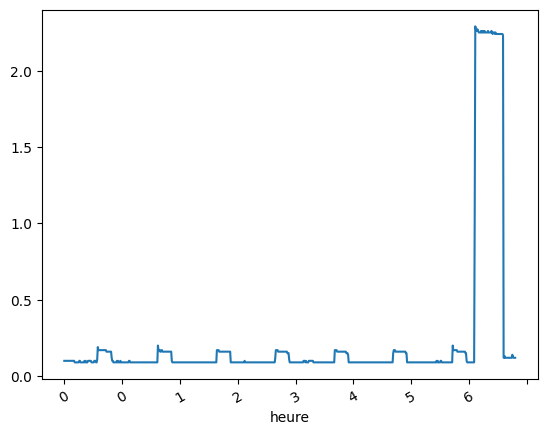

In [371]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [372]:
end = time.time()
print(end - start)

22.150407075881958


### grouped by 'heure'

In [373]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 999219 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   781 non-null    int64         
 1   kWh        781 non-null    float64       
 2   sec        781 non-null    float64       
 3   Wh         781 non-null    float64       
 4   cumul(ms)  781 non-null    int64         
 5   dates      781 non-null    datetime64[ns]
 6   days       781 non-null    object        
 7   heure      781 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 54.9+ KB


In [374]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999219,36219,0.10,36.219,99.395345,25962532489,2025-05-18 00:00:20.467245,18/05/25
999220,34296,0.10,34.296,104.968509,25962566785,2025-05-18 00:00:54.763245,18/05/25
999221,34327,0.10,34.327,104.873715,25962601112,2025-05-18 00:01:29.090245,18/05/25
999222,35615,0.10,35.615,101.081005,25962636727,2025-05-18 00:02:04.705245,18/05/25
999223,35918,0.10,35.918,100.228298,25962672645,2025-05-18 00:02:40.623245,18/05/25
...,...,...,...,...,...,...,...
999995,27810,0.13,27.810,129.449838,25987947040,2025-05-18 07:03:55.018245,18/05/25
999996,29681,0.12,29.681,121.289714,25987976721,2025-05-18 07:04:24.699245,18/05/25
999997,29490,0.12,29.490,122.075280,25988006211,2025-05-18 07:04:54.189245,18/05/25
999998,29640,0.12,29.640,121.457490,25988035851,2025-05-18 07:05:23.829245,18/05/25


In [375]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [376]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0    107
1    102
2    102
3    102
4    101
5    102
6    152
7     13
Name: kWh, dtype: int64

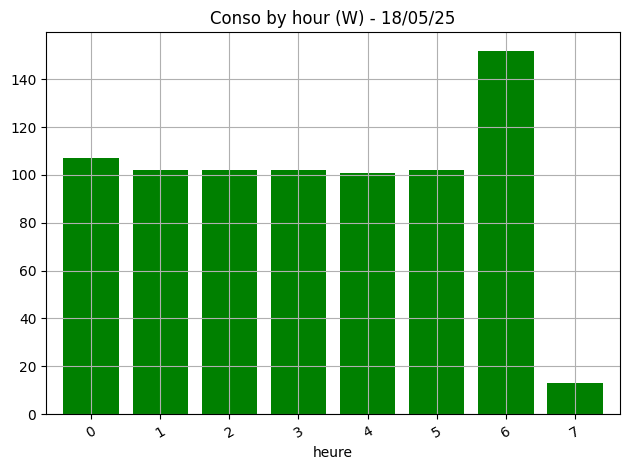

In [377]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [378]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 21/07/24 to 18/05/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     302 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [379]:
# give the periods of 1 kwh in a day
period()

2025-05-18 00:00:20.467245	2025-05-18 07:05:53.079245	7h 5m 32s 	781


In [380]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [381]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [382]:
df_grp.mean()


kWh    3.311258
dtype: float64

In [383]:
df_grp.head()


,kWh
days,
21/07/24,2.072
22/07/24,3.558
23/07/24,3.700
24/07/24,3.601
25/07/24,3.431


In [384]:
df_grp.tail()


,kWh
days,
14/05/25,3.203
15/05/25,3.482
16/05/25,3.042
17/05/25,3.531
18/05/25,0.781


In [385]:
end = time.time()
print(end - start)

23.048112154006958


# plot les 100 derniers jours


In [386]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.41117
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

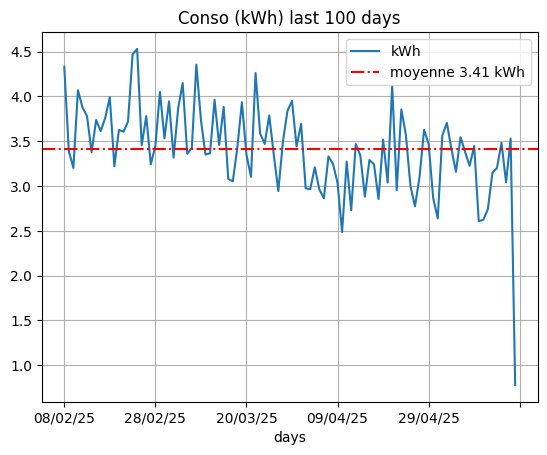

In [387]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [388]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,0.781
max,4.531


In [389]:
end = time.time()
print(end - start)

23.79695153236389


In [390]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('18/04/25', '13/05/25')

In [391]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.2408
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

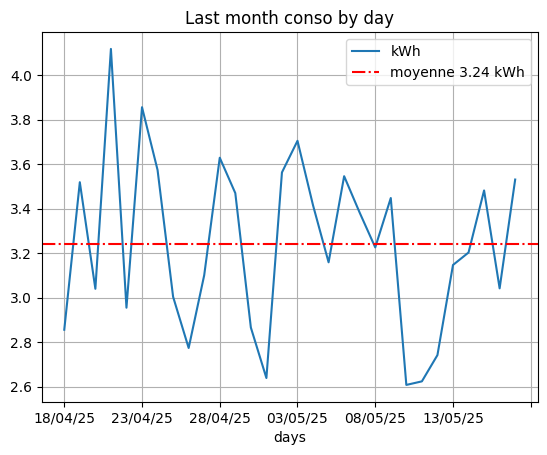

In [392]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [393]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 21/04/25 4.118
Min : 10/05/25 2.608


# Temps de conso par tranche de 1 kWh

In [394]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


1
2025-05-18 00:00:20.467245	2025-05-18 07:05:53.079245	7h 5m 32s 	781


In [395]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('07:06:07', 0.781, 781)

In [396]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 999219 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   781 non-null    int64         
 1   kWh        781 non-null    float64       
 2   sec        781 non-null    float64       
 3   Wh         781 non-null    float64       
 4   cumul(ms)  781 non-null    int64         
 5   dates      781 non-null    datetime64[ns]
 6   days       781 non-null    object        
 7   heure      781 non-null    object        
 8   hours      781 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 61.0+ KB


In [397]:
conso_hours['heure'], conso_hours['hours']

(999219    0
 999220    0
 999221    0
 999222    0
 999223    0
          ..
 999995    7
 999996    7
 999997    7
 999998    7
 999999    7
 Name: heure, Length: 781, dtype: object,
 999219    00
 999220    00
 999221    00
 999222    00
 999223    00
           ..
 999995    07
 999996    07
 999997    07
 999998    07
 999999    07
 Name: hours, Length: 781, dtype: object)

In [398]:
end = time.time()
print(end - start)

24.502192497253418


# select number of days to display


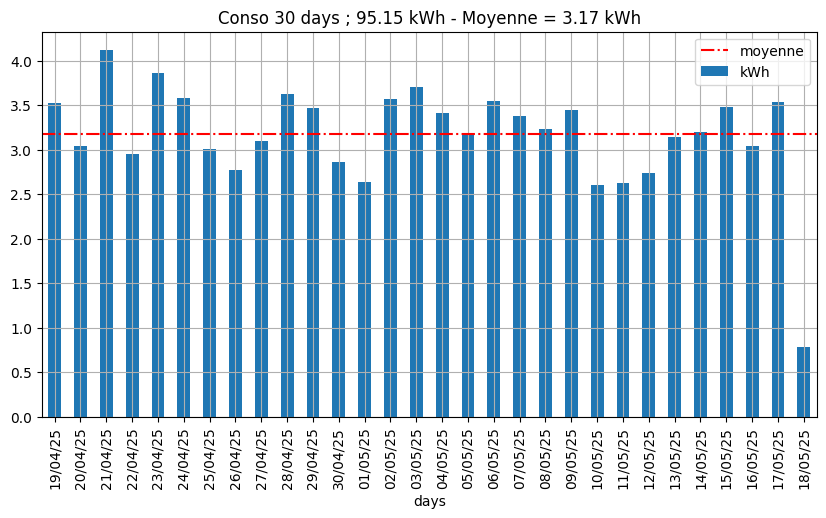

In [399]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


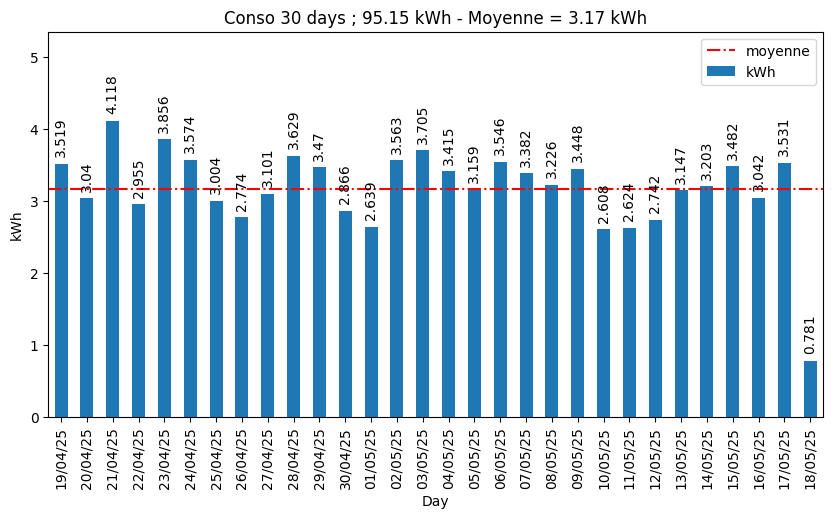

In [400]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [401]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
19/04/25    3.519
20/04/25    3.040
21/04/25    4.118
22/04/25    2.955
23/04/25    3.856
24/04/25    3.574
25/04/25    3.004
26/04/25    2.774
27/04/25    3.101
28/04/25    3.629
29/04/25    3.470
30/04/25    2.866
01/05/25    2.639
02/05/25    3.563
03/05/25    3.705
04/05/25    3.415
05/05/25    3.159
06/05/25    3.546
07/05/25    3.382
08/05/25    3.226
09/05/25    3.448
10/05/25    2.608
11/05/25    2.624
12/05/25    2.742
13/05/25    3.147
14/05/25    3.203
15/05/25    3.482
16/05/25    3.042
17/05/25    3.531
18/05/25    0.781
Name: kWh, dtype: float64

In [402]:
x_labels=df_grp.tail(span).index
x_labels

Index(['19/04/25', '20/04/25', '21/04/25', '22/04/25', '23/04/25', '24/04/25',
       '25/04/25', '26/04/25', '27/04/25', '28/04/25', '29/04/25', '30/04/25',
       '01/05/25', '02/05/25', '03/05/25', '04/05/25', '05/05/25', '06/05/25',
       '07/05/25', '08/05/25', '09/05/25', '10/05/25', '11/05/25', '12/05/25',
       '13/05/25', '14/05/25', '15/05/25', '16/05/25', '17/05/25', '18/05/25'],
      dtype='object', name='days')

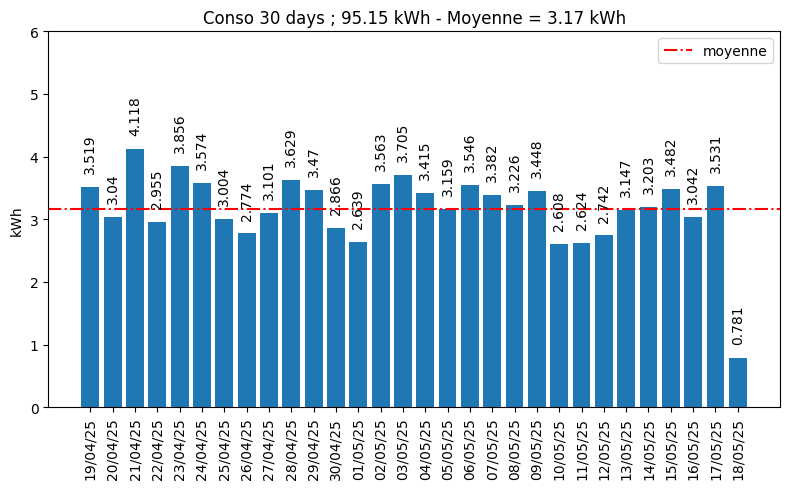

In [403]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [404]:
end = time.time()
print(end - start)

27.711699724197388


In [405]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

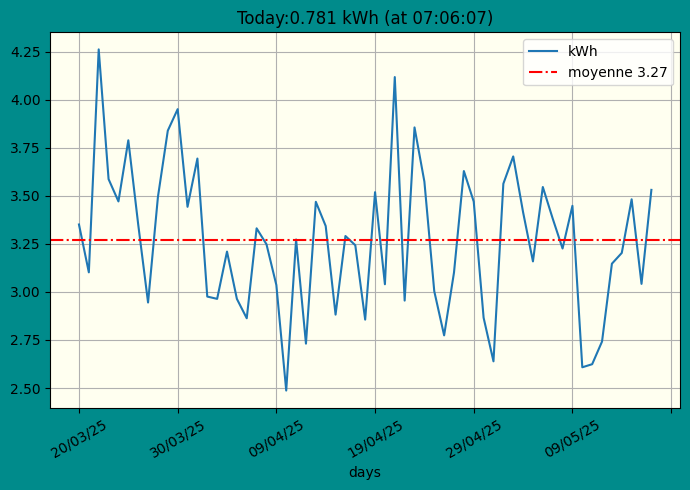

In [406]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

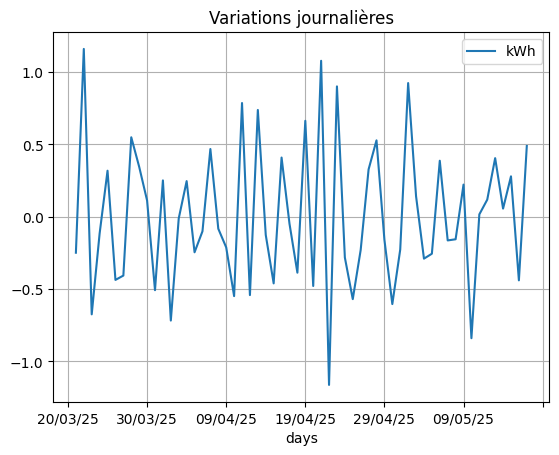

In [407]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [408]:
end = time.time()
print(end - start)

28.65175986289978


# Data from 21/08/23

In [409]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,17883,0.20,17.883,201.308505,17883,2024-07-21 12:11:45.861245,21/07/24,12,2024-07,21
1,17966,0.20,17.966,200.378493,35849,2024-07-21 12:12:03.827245,21/07/24,12,2024-07,21
2,17859,0.20,17.859,201.579036,53708,2024-07-21 12:12:21.686245,21/07/24,12,2024-07,21
3,17988,0.20,17.988,200.133422,71696,2024-07-21 12:12:39.674245,21/07/24,12,2024-07,21
4,18097,0.20,18.097,198.927999,89793,2024-07-21 12:12:57.771245,21/07/24,12,2024-07,21
...,...,...,...,...,...,...,...,...,...,...
999995,27810,0.13,27.810,129.449838,25987947040,2025-05-18 07:03:55.018245,18/05/25,07,2025-05,18
999996,29681,0.12,29.681,121.289714,25987976721,2025-05-18 07:04:24.699245,18/05/25,07,2025-05,18
999997,29490,0.12,29.490,122.075280,25988006211,2025-05-18 07:04:54.189245,18/05/25,07,2025-05,18
999998,29640,0.12,29.640,121.457490,25988035851,2025-05-18 07:05:23.829245,18/05/25,07,2025-05,18


In [410]:
end = time.time()
print(end - start)

64.18703293800354


In [411]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

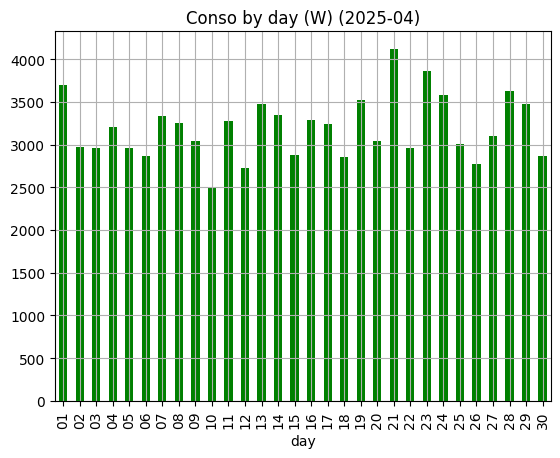

In [412]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [413]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3192.233333333333)

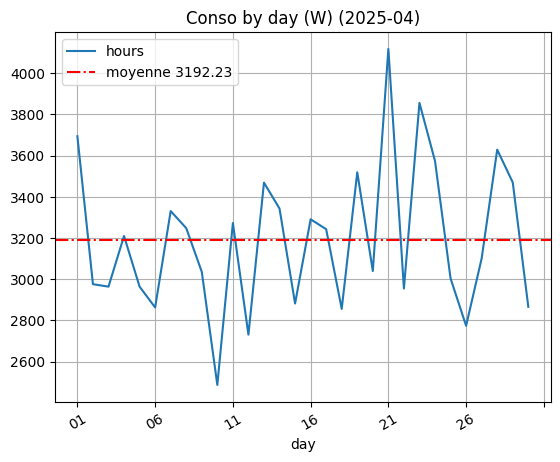

In [414]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [415]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

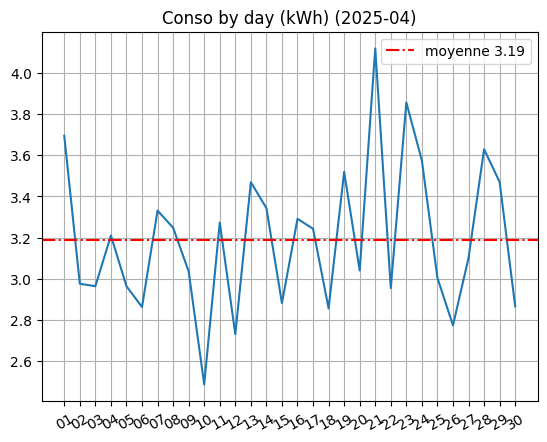

In [416]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [417]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [418]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [419]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-07,36114,36114,36114
2024-08,117338,117338,117338
2024-09,69792,69792,69792
2024-10,73490,73490,73490
2024-11,108516,108516,108516
2024-12,113733,113733,113733
2025-01,113666,113666,113666
2025-02,104478,104478,104478
2025-03,111863,111863,111863


In [420]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [421]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [422]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
21/07/24,2072
22/07/24,3558
23/07/24,3700
24/07/24,3601
25/07/24,3431
...,...
14/05/25,3203
15/05/25,3482
16/05/25,3042


In [423]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,17883,0.20,17.883,201.308505,17883,2024-07-21 12:11:45.861245,21/07/24,12,2024-07,21
1,17966,0.20,17.966,200.378493,35849,2024-07-21 12:12:03.827245,21/07/24,12,2024-07,21
2,17859,0.20,17.859,201.579036,53708,2024-07-21 12:12:21.686245,21/07/24,12,2024-07,21
3,17988,0.20,17.988,200.133422,71696,2024-07-21 12:12:39.674245,21/07/24,12,2024-07,21
4,18097,0.20,18.097,198.927999,89793,2024-07-21 12:12:57.771245,21/07/24,12,2024-07,21
...,...,...,...,...,...,...,...,...,...,...
999995,27810,0.13,27.810,129.449838,25987947040,2025-05-18 07:03:55.018245,18/05/25,07,2025-05,18
999996,29681,0.12,29.681,121.289714,25987976721,2025-05-18 07:04:24.699245,18/05/25,07,2025-05,18
999997,29490,0.12,29.490,122.075280,25988006211,2025-05-18 07:04:54.189245,18/05/25,07,2025-05,18
999998,29640,0.12,29.640,121.457490,25988035851,2025-05-18 07:05:23.829245,18/05/25,07,2025-05,18


In [424]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
21/07/24 12    0       21/07/24    12  0.20
               1       21/07/24    12  0.20
               2       21/07/24    12  0.20
               3       21/07/24    12  0.20
               4       21/07/24    12  0.20
...                         ...   ...   ...
18/05/25 07    999995  18/05/25    07  0.13
               999996  18/05/25    07  0.12
               999997  18/05/25    07  0.12
               999998  18/05/25    07  0.12
               999999  18/05/25    07  0.12

[1000000 rows x 3 columns]

In [425]:
groupallbyday.indices.keys()

dict_keys(['21/07/24', '22/07/24', '23/07/24', '24/07/24', '25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/08/24', '25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/1

In [426]:
groupallbydayhours.indices.keys()

dict_keys([('21/07/24', '12'), ('21/07/24', '13'), ('21/07/24', '14'), ('21/07/24', '15'), ('21/07/24', '16'), ('21/07/24', '17'), ('21/07/24', '18'), ('21/07/24', '19'), ('21/07/24', '20'), ('21/07/24', '21'), ('21/07/24', '22'), ('21/07/24', '23'), ('22/07/24', '12'), ('22/07/24', '13'), ('22/07/24', '14'), ('22/07/24', '15'), ('22/07/24', '16'), ('22/07/24', '17'), ('22/07/24', '18'), ('22/07/24', '19'), ('22/07/24', '20'), ('22/07/24', '21'), ('22/07/24', '22'), ('22/07/24', '23'), ('22/07/24', '00'), ('22/07/24', '01'), ('22/07/24', '02'), ('22/07/24', '03'), ('22/07/24', '04'), ('22/07/24', '05'), ('22/07/24', '06'), ('22/07/24', '07'), ('22/07/24', '08'), ('22/07/24', '09'), ('22/07/24', '10'), ('22/07/24', '11'), ('23/07/24', '12'), ('23/07/24', '13'), ('23/07/24', '14'), ('23/07/24', '15'), ('23/07/24', '16'), ('23/07/24', '17'), ('23/07/24', '18'), ('23/07/24', '19'), ('23/07/24', '20'), ('23/07/24', '21'), ('23/07/24', '22'), ('23/07/24', '23'), ('23/07/24', '00'), ('23/07/2

In [427]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
21/07/24,2072,2072
22/07/24,3558,3558
23/07/24,3700,3700
24/07/24,3601,3601
25/07/24,3431,3431
...,...,...
14/05/25,3203,3203
15/05/25,3482,3482
16/05/25,3042,3042


In [428]:
grp_by_day['kWh'].cumsum()

days
21/07/24       2072
22/07/24       5630
23/07/24       9330
24/07/24      12931
25/07/24      16362
             ...   
14/05/25     989164
15/05/25     992646
16/05/25     995688
17/05/25     999219
18/05/25    1000000
Name: kWh, Length: 302, dtype: int64

In [429]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
21/07/24 12     108
         13     190
         14     156
         15     164
         16     279
...             ...
18/05/25 03     102
         04     101
         05     102
         06     152
         07      13

[7220 rows x 1 columns]

In [430]:
grp_by_dayhours['kWh'].cumsum()

days      hours
21/07/24  12           108
          13           298
          14           454
          15           618
          16           897
                    ...   
18/05/25  03        999632
          04        999733
          05        999835
          06        999987
          07       1000000
Name: kWh, Length: 7220, dtype: int64

In [431]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
21/07/24 12     108     108    NaN
         13     190     298   82.0
         14     156     454  -34.0
         15     164     618    8.0
         16     279     897  115.0
...             ...     ...    ...
18/05/25 03     102     413    0.0
         04     101     514   -1.0
         05     102     616    1.0
         06     152     768   50.0
         07      13     781 -139.0

[7220 rows x 3 columns]

In [432]:
today, grp_by_dayhours.loc[today]

('18/05/25',
        kWh  cumsum   diff
 hours                    
 00     107     107    NaN
 01     102     209   -5.0
 02     102     311    0.0
 03     102     413    0.0
 04     101     514   -1.0
 05     102     616    1.0
 06     152     768   50.0
 07      13     781 -139.0)

Text(0.5, 1.0, 'Cumul journalier')

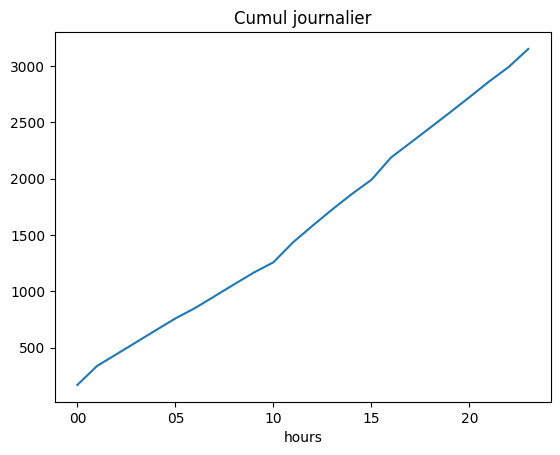

In [433]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

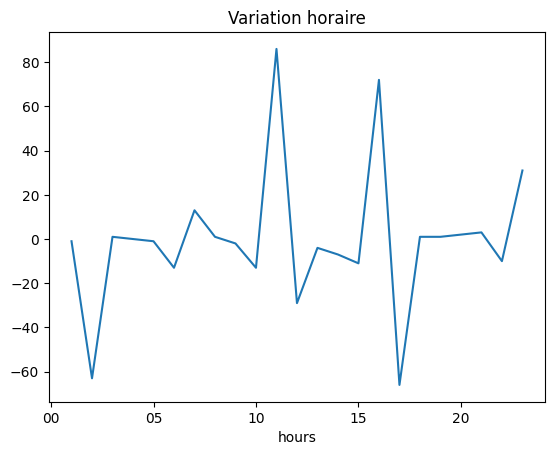

In [434]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [435]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

302

In [436]:
df_grp.tail(n)['kWh'].describe()


count    302.000000
mean       3.311258
std        0.742421
min        0.781000
25%        3.101250
50%        3.448000
75%        3.779500
max        4.808000
Name: kWh, dtype: float64

In [437]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [438]:
n, np.nanmean(df_grp.tail(n))

(302, np.float64(3.3112582781456954))

Text(0.5, 1.0, '302 days')

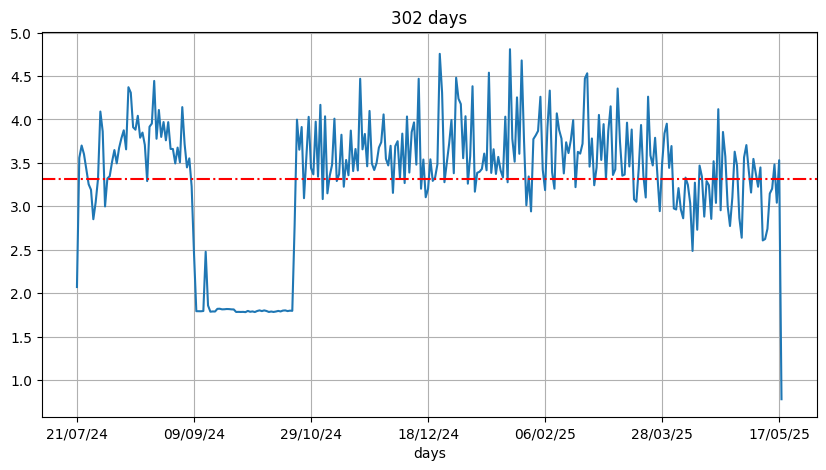

In [439]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

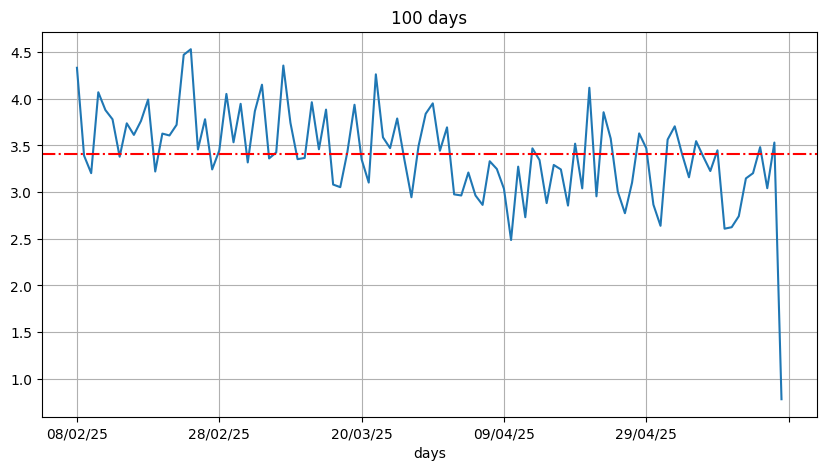

In [440]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

In [441]:
np.nanmean(df_grp.tail(span))

np.float64(3.4111700000000003)

In [442]:
df_grp['kWh']

days
21/07/24    2.072
22/07/24    3.558
23/07/24    3.700
24/07/24    3.601
25/07/24    3.431
            ...  
14/05/25    3.203
15/05/25    3.482
16/05/25    3.042
17/05/25    3.531
18/05/25    0.781
Name: kWh, Length: 302, dtype: float64

In [443]:
df_grp.describe()

,kWh
count,302.000000
mean,3.311258
std,0.742421
min,0.781000
25%,3.101250
50%,3.448000
75%,3.779500
max,4.808000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

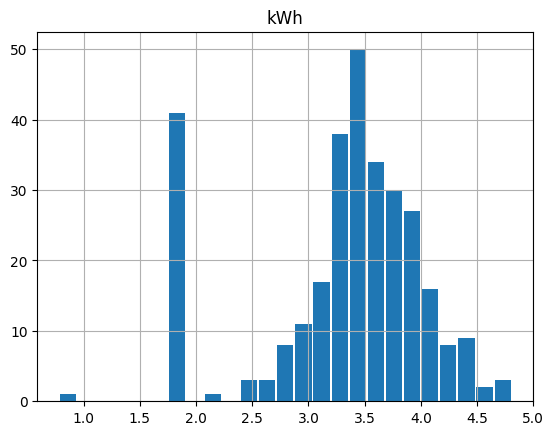

In [444]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [445]:
df_grp.tail(span)['kWh']

days
08/02/25    4.332
09/02/25    3.391
10/02/25    3.203
11/02/25    4.070
12/02/25    3.879
            ...  
14/05/25    3.203
15/05/25    3.482
16/05/25    3.042
17/05/25    3.531
18/05/25    0.781
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [446]:
day

'18/05/25'

In [447]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,107,107,NaN
01,102,209,-5.0
02,102,311,0.0
03,102,413,0.0
04,101,514,-1.0
05,102,616,1.0
06,152,768,50.0
07,13,781,-139.0


In [448]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


8

In [449]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 9)

In [450]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [451]:
grp_by_dayhours.loc[day,'days'].values

array([1., 2., 3., 4., 5., 6., 7., 8.])

In [452]:
grp_by_dayhours.loc[day,'days']

hours
00    1.0
01    2.0
02    3.0
03    4.0
04    5.0
05    6.0
06    7.0
07    8.0
Name: days, dtype: float64

In [453]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [454]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 00 to 07
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     8 non-null      int64  
 1   cumsum  8 non-null      int64  
 2   diff    7 non-null      float64
 3   days    8 non-null      float64
dtypes: float64(2), int64(2)
memory usage: 320.0+ bytes


In [455]:
grp_by_dayhours.loc[day,'days']

hours
00    1.0
01    2.0
02    3.0
03    4.0
04    5.0
05    6.0
06    7.0
07    8.0
Name: days, dtype: float64

In [456]:
day

'18/05/25'

In [457]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,107,107,NaN,1.0
01,102,209,-5.0,2.0
02,102,311,0.0,3.0
03,102,413,0.0,4.0
04,101,514,-1.0,5.0
05,102,616,1.0,6.0
06,152,768,50.0,7.0
07,13,781,-139.0,8.0


In [458]:
kwh = grp_by_dayhours.loc[day][['kWh']]
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_12648\3891495459.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.int64(781)

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '18/05/25: kWh    781\ndtype: int64')

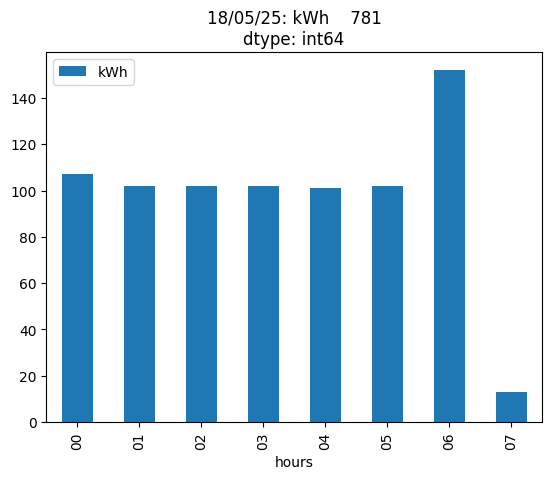

In [459]:
kwh.plot.bar()
plt.title(f'{day}: {np.sum(kwh)}')

In [460]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07'], dtype='object', name='hours')

# Conso du jour


In [461]:

grp_by_dayhours.count()

kWh       7220
cumsum    7220
diff      6918
days         8
dtype: int64

'22/01/25'

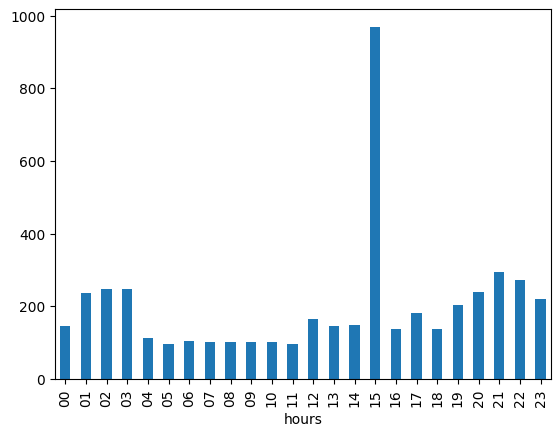

In [462]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [463]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

In [464]:
df_grp.tail(7)['kWh']

days
12/05/25    2.742
13/05/25    3.147
14/05/25    3.203
15/05/25    3.482
16/05/25    3.042
17/05/25    3.531
18/05/25    0.781
Name: kWh, dtype: float64

Total= 341.117 , Moyenne= 3.4111700000000003


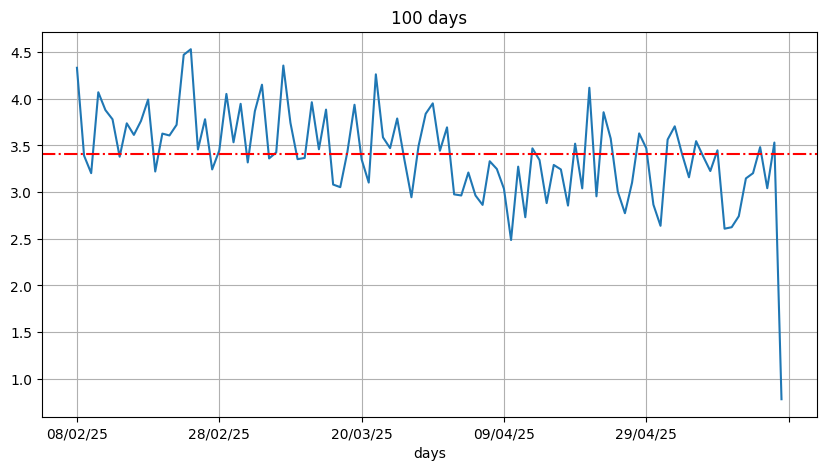

In [465]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [466]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 07:07:08, Minutes in day: 427


In [467]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [468]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:19.41


In [469]:
end - start

79.4067587852478

In [470]:
#df = conso_day
show_tranches()

1
2025-05-18 00:00:20.467245	2025-05-18 07:05:53.079245	7h 5m 32s 	781


# Today

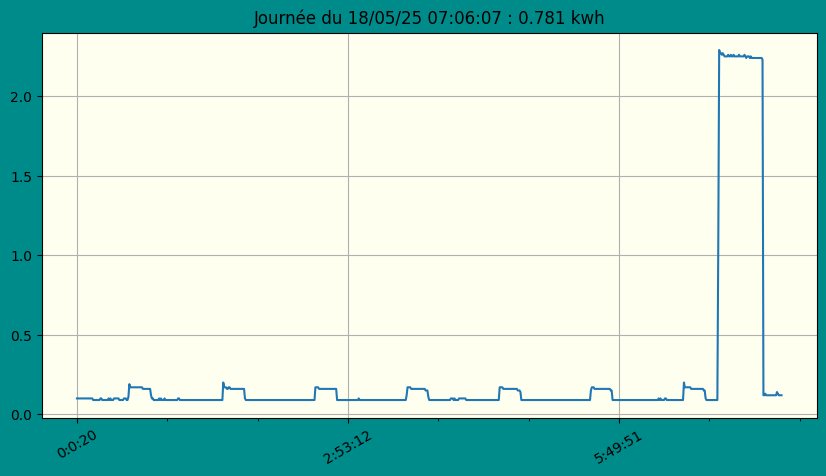

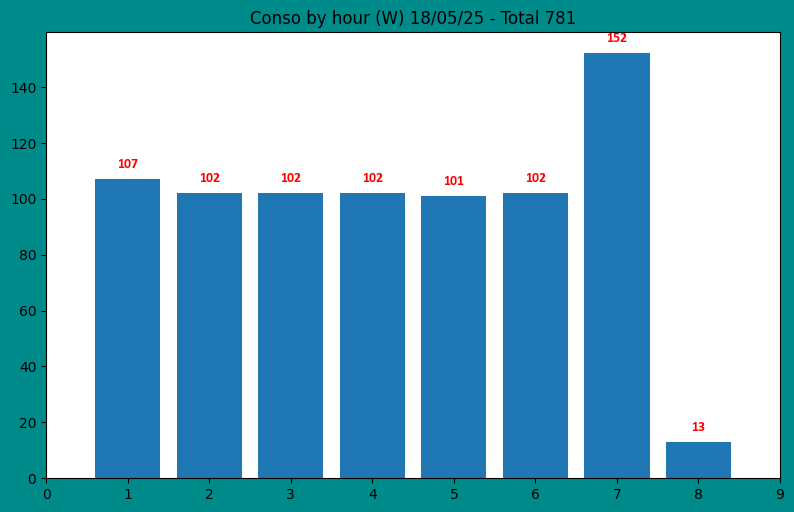

In [471]:
show(today,bgcolor='ivory')
conso_by_hour(today)

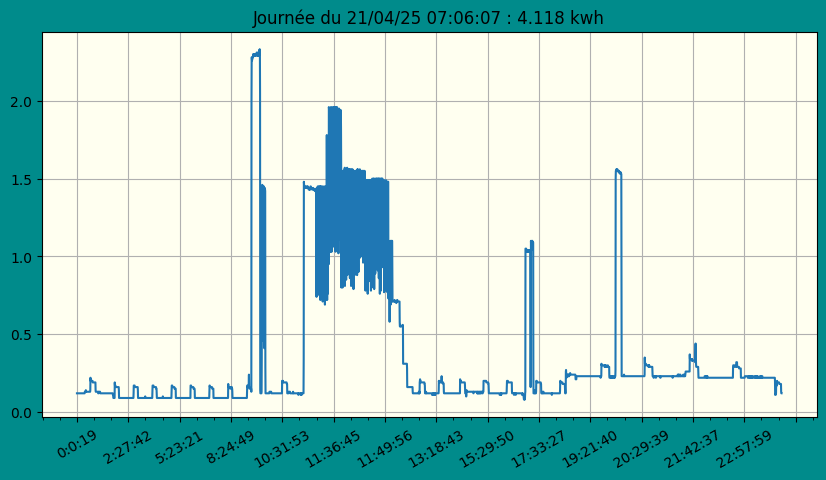

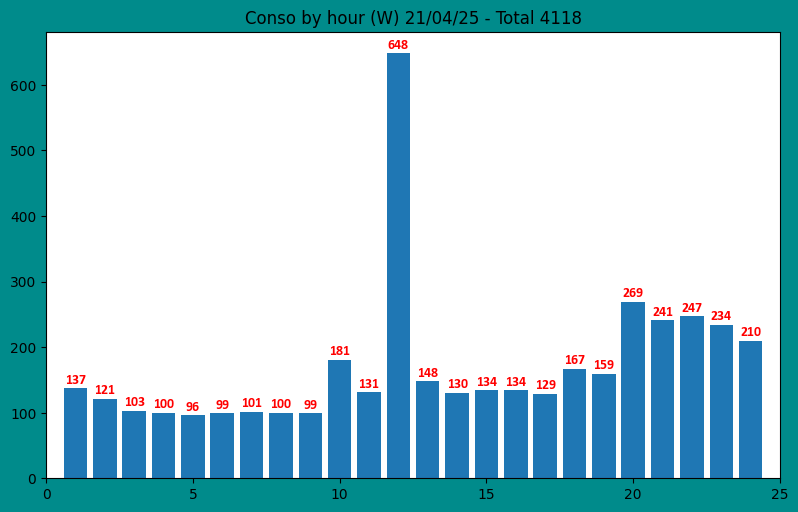

In [472]:
day = '21/04/25' # 21/04/25 cuisine midi et télé le soir 4.115 kWh
day, show(day,bgcolor='ivory')
conso_by_hour(day)

22/01/25


(None, 4808)

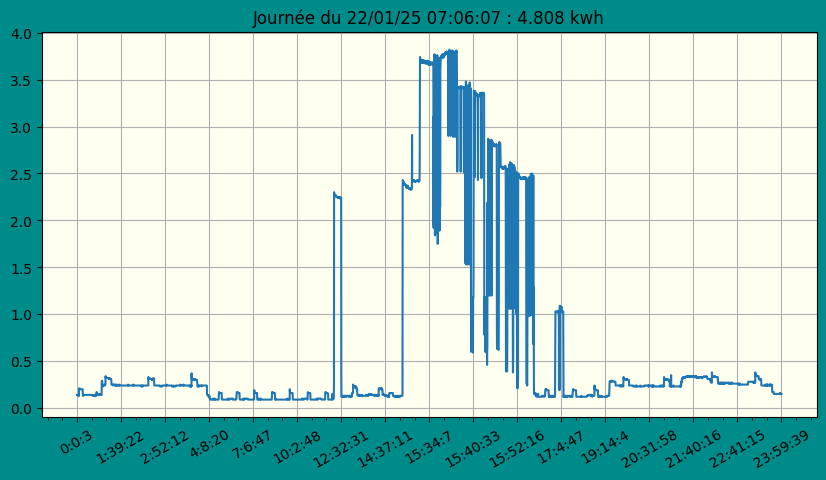

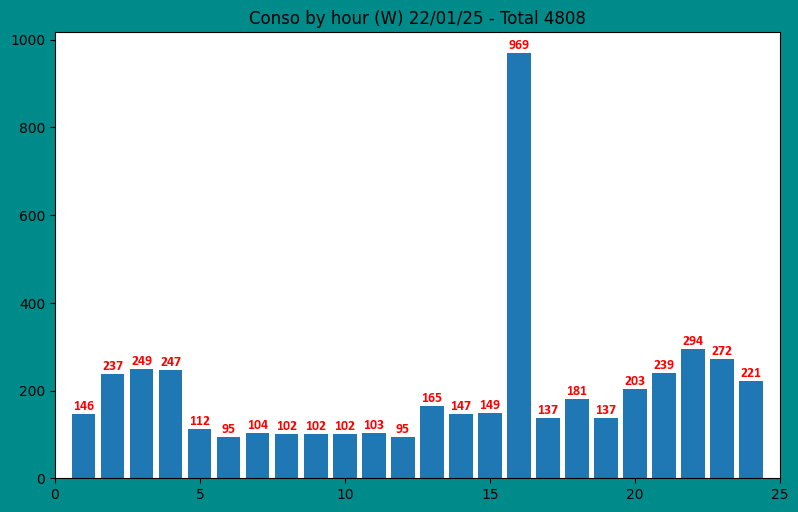

In [473]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

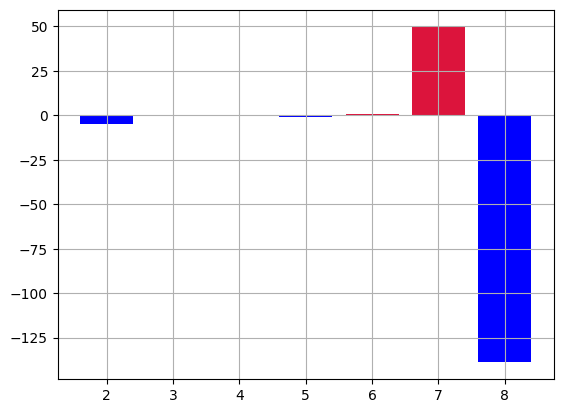

In [474]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

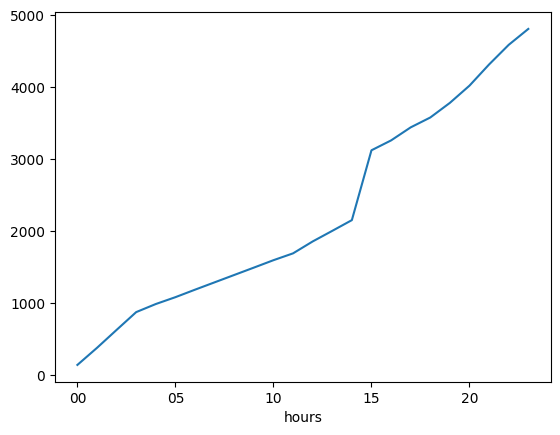

In [475]:
data.cumsum().plot()


<Axes: xlabel='hours'>

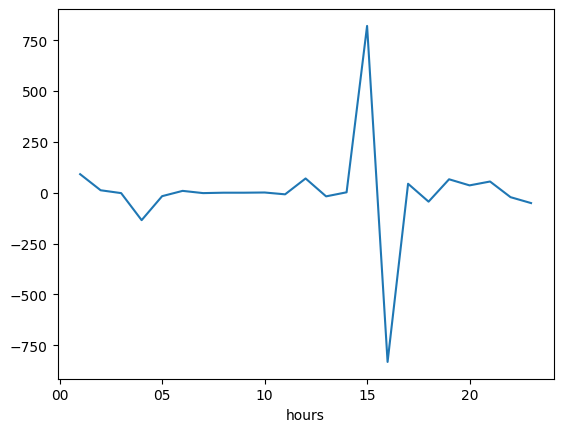

In [476]:
# evolution par heure
data.diff().plot()

In [477]:
data.diff().describe()

count     23.000000
mean       3.260870
std      253.371308
min     -832.000000
25%      -17.500000
50%        0.000000
75%       40.000000
max      820.000000
Name: kWh, dtype: float64

<Axes: >

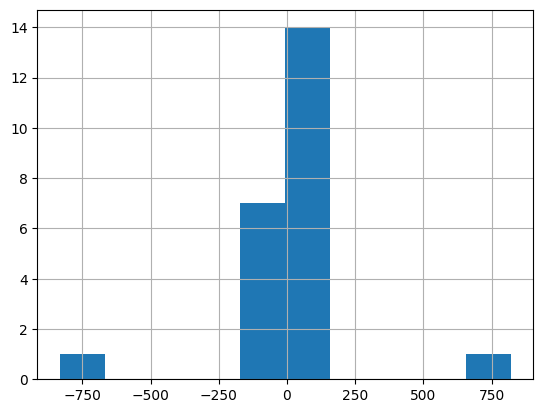

In [478]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [479]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo

# list store files csv


In [480]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('22/01/25', None)

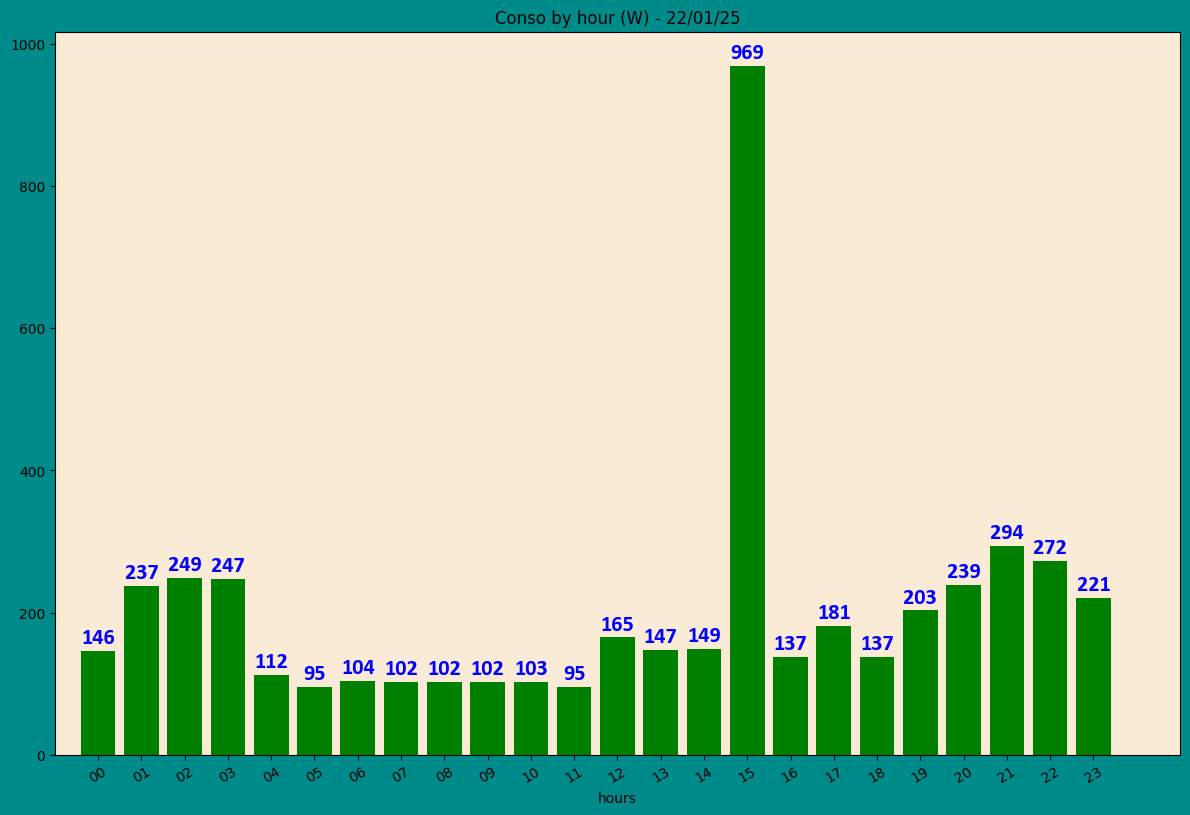

In [481]:
day,conso_byhour(day)

In [482]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


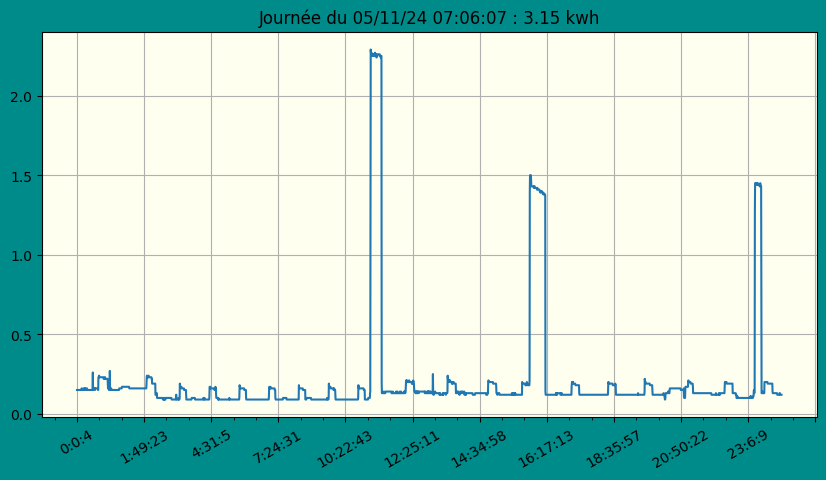

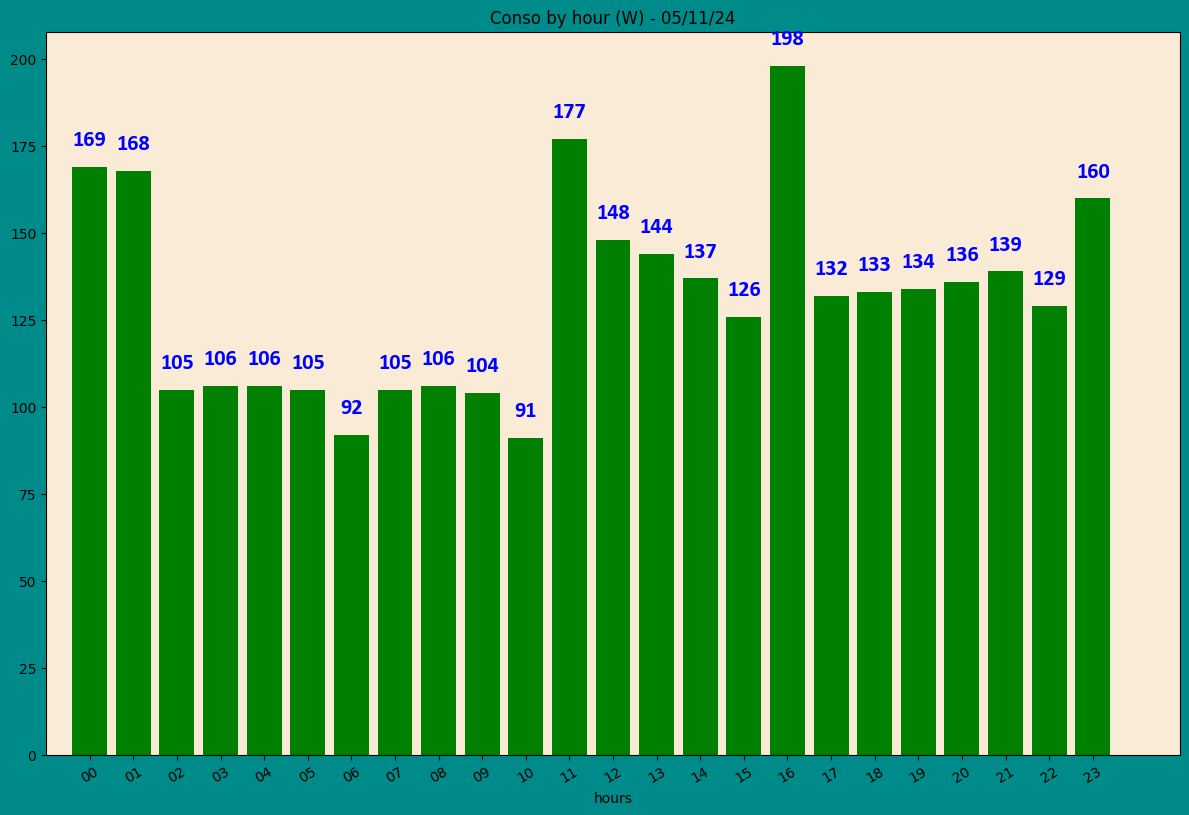

In [483]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [484]:
month

,day,hours,months,kWh
848990,01,00,2025-04,0.20
848991,01,00,2025-04,0.20
848992,01,00,2025-04,0.20
848993,01,00,2025-04,0.20
848994,01,00,2025-04,0.20
...,...,...,...,...
944752,30,23,2025-04,0.09
944753,30,23,2025-04,0.09
944754,30,23,2025-04,0.09
944755,30,23,2025-04,0.09


In [485]:
month.describe()


,kWh
count,95767.000000
mean,0.310166
std,0.548085
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

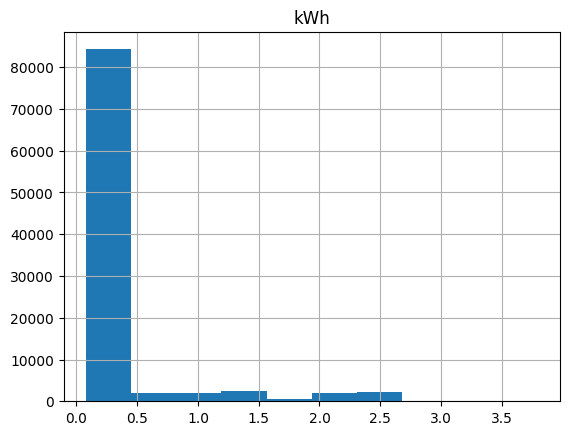

In [486]:
month.hist()

<Axes: >

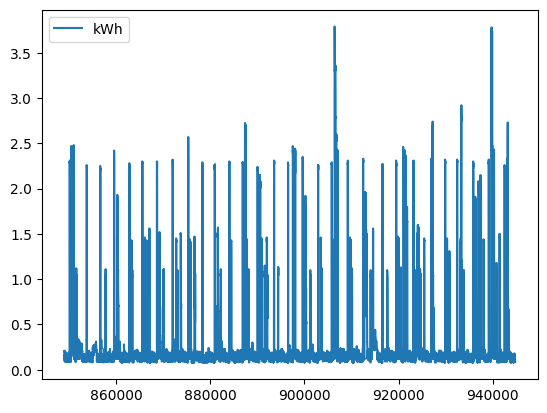

In [487]:
month.plot()

In [488]:
# index with max conso in this month
month.idxmax().kWh

np.int64(906409)

In [489]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       941891
hours     852470
months    848990
kWh       906409
dtype: int64

In [490]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [491]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
21/07/24 12     108     108    NaN   NaN
         13     190     298   82.0   NaN
         14     156     454  -34.0   NaN
         15     164     618    8.0   NaN
         16     279     897  115.0   NaN
...             ...     ...    ...   ...
18/05/25 03     102     413    0.0   4.0
         04     101     514   -1.0   5.0
         05     102     616    1.0   6.0
         06     152     768   50.0   7.0
         07      13     781 -139.0   8.0

[7220 rows x 4 columns]

In [492]:
month

,day,hours,months,kWh
848990,01,00,2025-04,0.20
848991,01,00,2025-04,0.20
848992,01,00,2025-04,0.20
848993,01,00,2025-04,0.20
848994,01,00,2025-04,0.20
...,...,...,...,...
944752,30,23,2025-04,0.09
944753,30,23,2025-04,0.09
944754,30,23,2025-04,0.09
944755,30,23,2025-04,0.09


In [493]:
month.idxmax()


day       941891
hours     852470
months    848990
kWh       906409
dtype: int64

In [494]:
month.loc[month.idxmax().kWh]


day            19
hours          12
months    2025-04
kWh          3.79
Name: 906409, dtype: object

In [495]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       171
          01       118
          02       114
          03       110
          04       109
          05       100
          06       111
          07       110
          08       109
          09        98
          10       171
          11       144
          12       147
          13       134
          14       202
          15       142
          16       153
          17       197
          18       144
          19       149
          20       140
          21       175
          22       225
          23       173
Name: kWh, dtype: int64

In [496]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'22'

<Axes: xlabel='days,hours'>

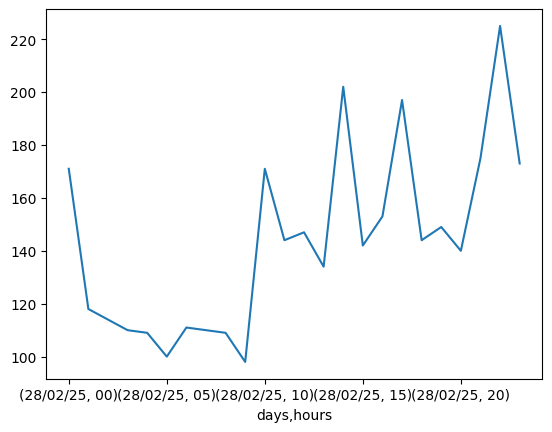

In [497]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [498]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [499]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [500]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [501]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB